# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Import all the utility functions
import pickle
import random
from random import randint
import csv
import os
import time

# Import the data processing libs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# Import OpenCV
import cv2

# Import the Deep Learning libs
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from skimage import exposure
from sklearn.model_selection import train_test_split

In [2]:
# Location of the pickle file
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

# Load the data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Split features and labels
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# The shape of an image?
image_shape = (X_train.shape[1], X_train.shape[2])

# Number of classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples = {}".format(n_train))
print("Number of testing examples = {}".format(n_test))
print("Image data shape = {}".format(image_shape))
print("Number of classes = {}".format(n_classes))

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [5]:
# Save the sign names in a dictionary
SignNames = {}

# Read the CSV file
with open('signnames.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        if row[0] != 'ClassId':
            SignNames[int(row[0])] = row[1]

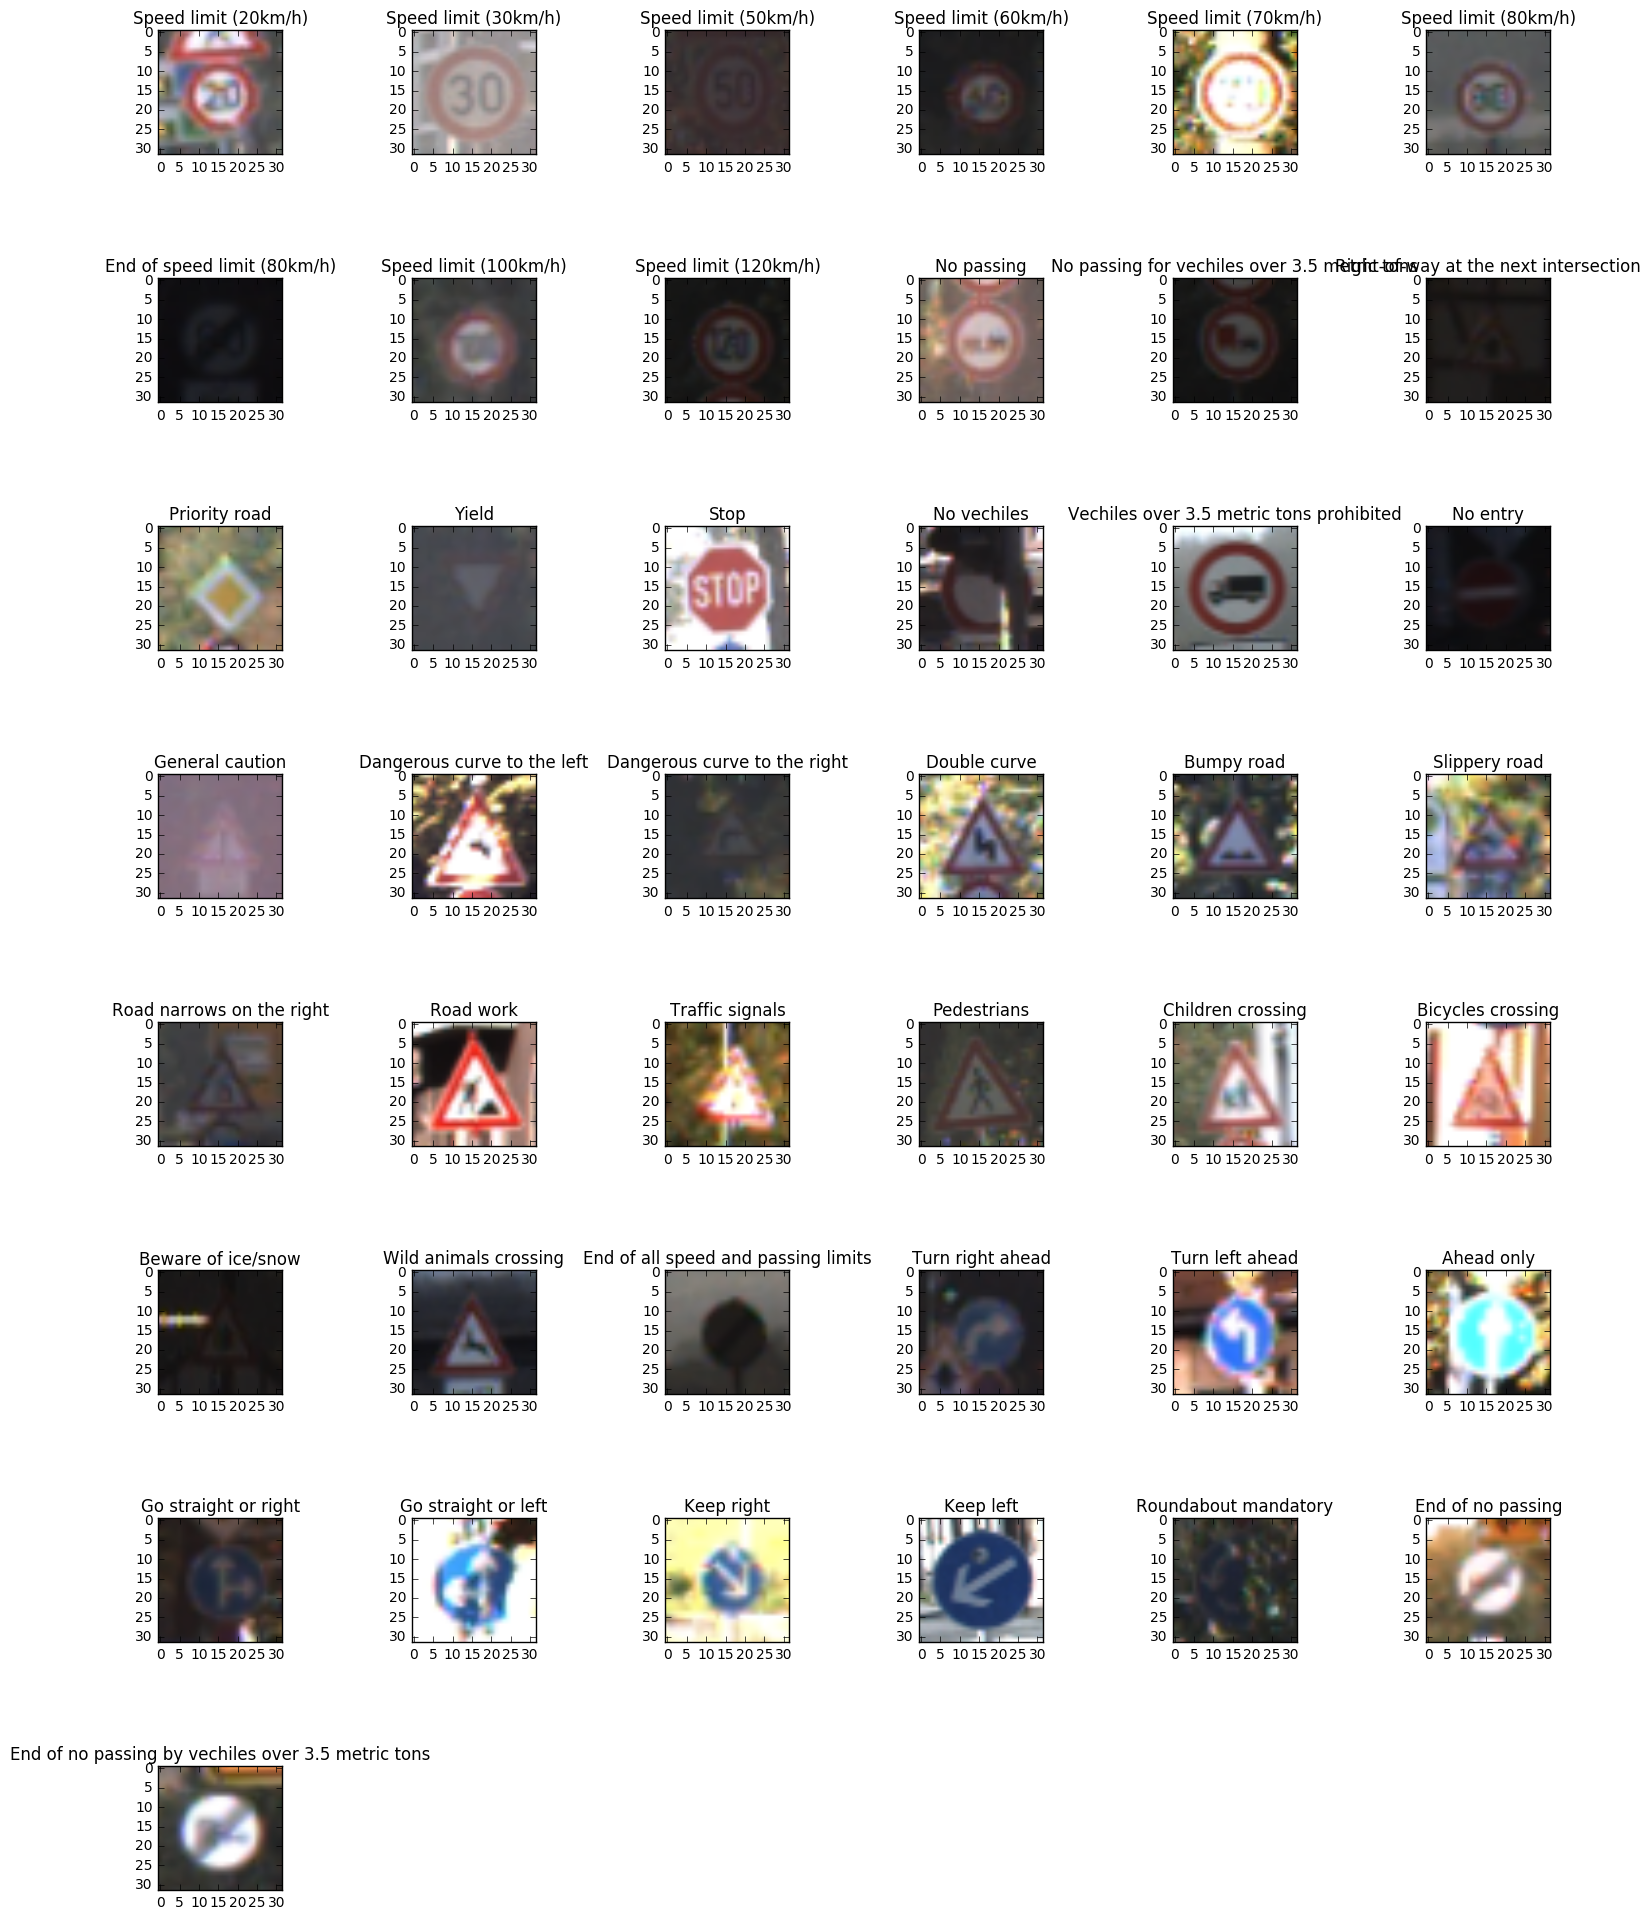

In [6]:
""" DISPLAY SOME OF THE IMAGES """
def displaySomeImages(_x, _y):
    # Get the list of classes
    values, counts = np.unique(_y, return_counts=True)

    # Loop through the classes and show an image per class
    i = 0
    fig = plt.figure(figsize=(18, 24))
    gs = gridspec.GridSpec(8,6, wspace = 1., hspace = 1.)
    for class_ in values:
        # Get the image
        idx = next(index for index, val in enumerate(_y) if val == class_)
        img = _x[idx]

        ax = fig.add_subplot(gs[i])
        ax.imshow(img, cmap = 'gray')
        ax.set_title(SignNames[_y[idx]])
        i += 1

displaySomeImages(X_train, y_train)

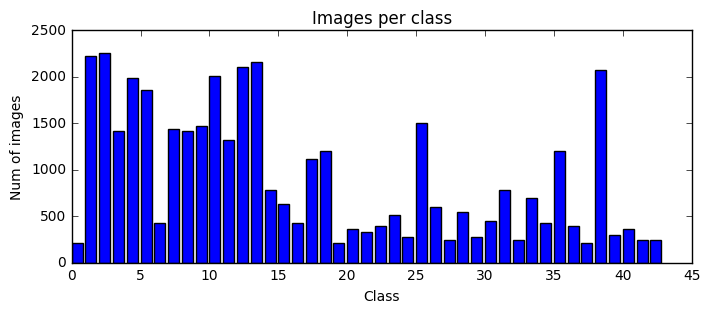

In [7]:
# Plot image type distribution
def plot_examples_per_class(labels_):
    values, counts = np.unique(labels_, return_counts=True)
    plt.figure(figsize=(8, 3))
    plt.bar(values, counts)
    plt.ylabel('Num of images')
    plt.xlabel('Class')
    plt.title('Images per class')
    
plot_examples_per_class(y_train)

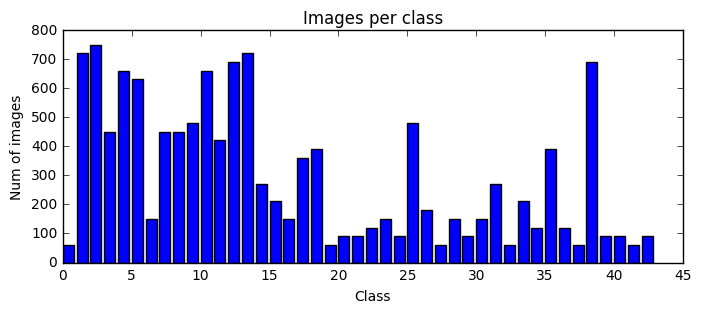

In [8]:
plot_examples_per_class(y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [9]:
def grayscale(_x):
    """
    Converts the array of images into grayscale
    
    Parameters
    ----------
    _x: The numpy array of images. Should be 4D (samples, h, w, d)
    return: Numpy array of grayscale images
    """
    ret = []
    for i in np.arange(_x.shape[0]):
        ret.append(cv2.cvtColor(_x[i,:,:,:], cv2.COLOR_BGR2GRAY))
    
    return np.array(ret)

def equalize(_x):
    """
    Equalizes the image histogram and also normalizes the image
    
    Parameters
    ----------
    _x: The numpy array of grayscale images. Should be 3D (samples, h, w)
    return: Processed image data
    """
    ret = []
    for img in _x:
        ret.append(exposure.equalize_adapthist(img))
        
    return np.array(ret)

def OneHot(_x):
    """
    Turns the labels into a one hot encoded vector
    
    Parameters
    ----------
    _x: The numpy array of labels. Should be 1D
    """
    encoder = LabelBinarizer()
    one_hot_encoded = encoder.fit_transform(_x)
    return one_hot_encoded


print('Success: Preprocessing functions loaded.')

Success: Preprocessing functions loaded.


In [10]:
# Preprocess Data
X_train_nrm = equalize(grayscale(X_train))
X_test_nrm = equalize(grayscale(X_test))
y_train_ohe = OneHot(y_train)
y_test_ohe = OneHot(y_test)

print('Success: Data preprocessed.')

Success: Data preprocessed.


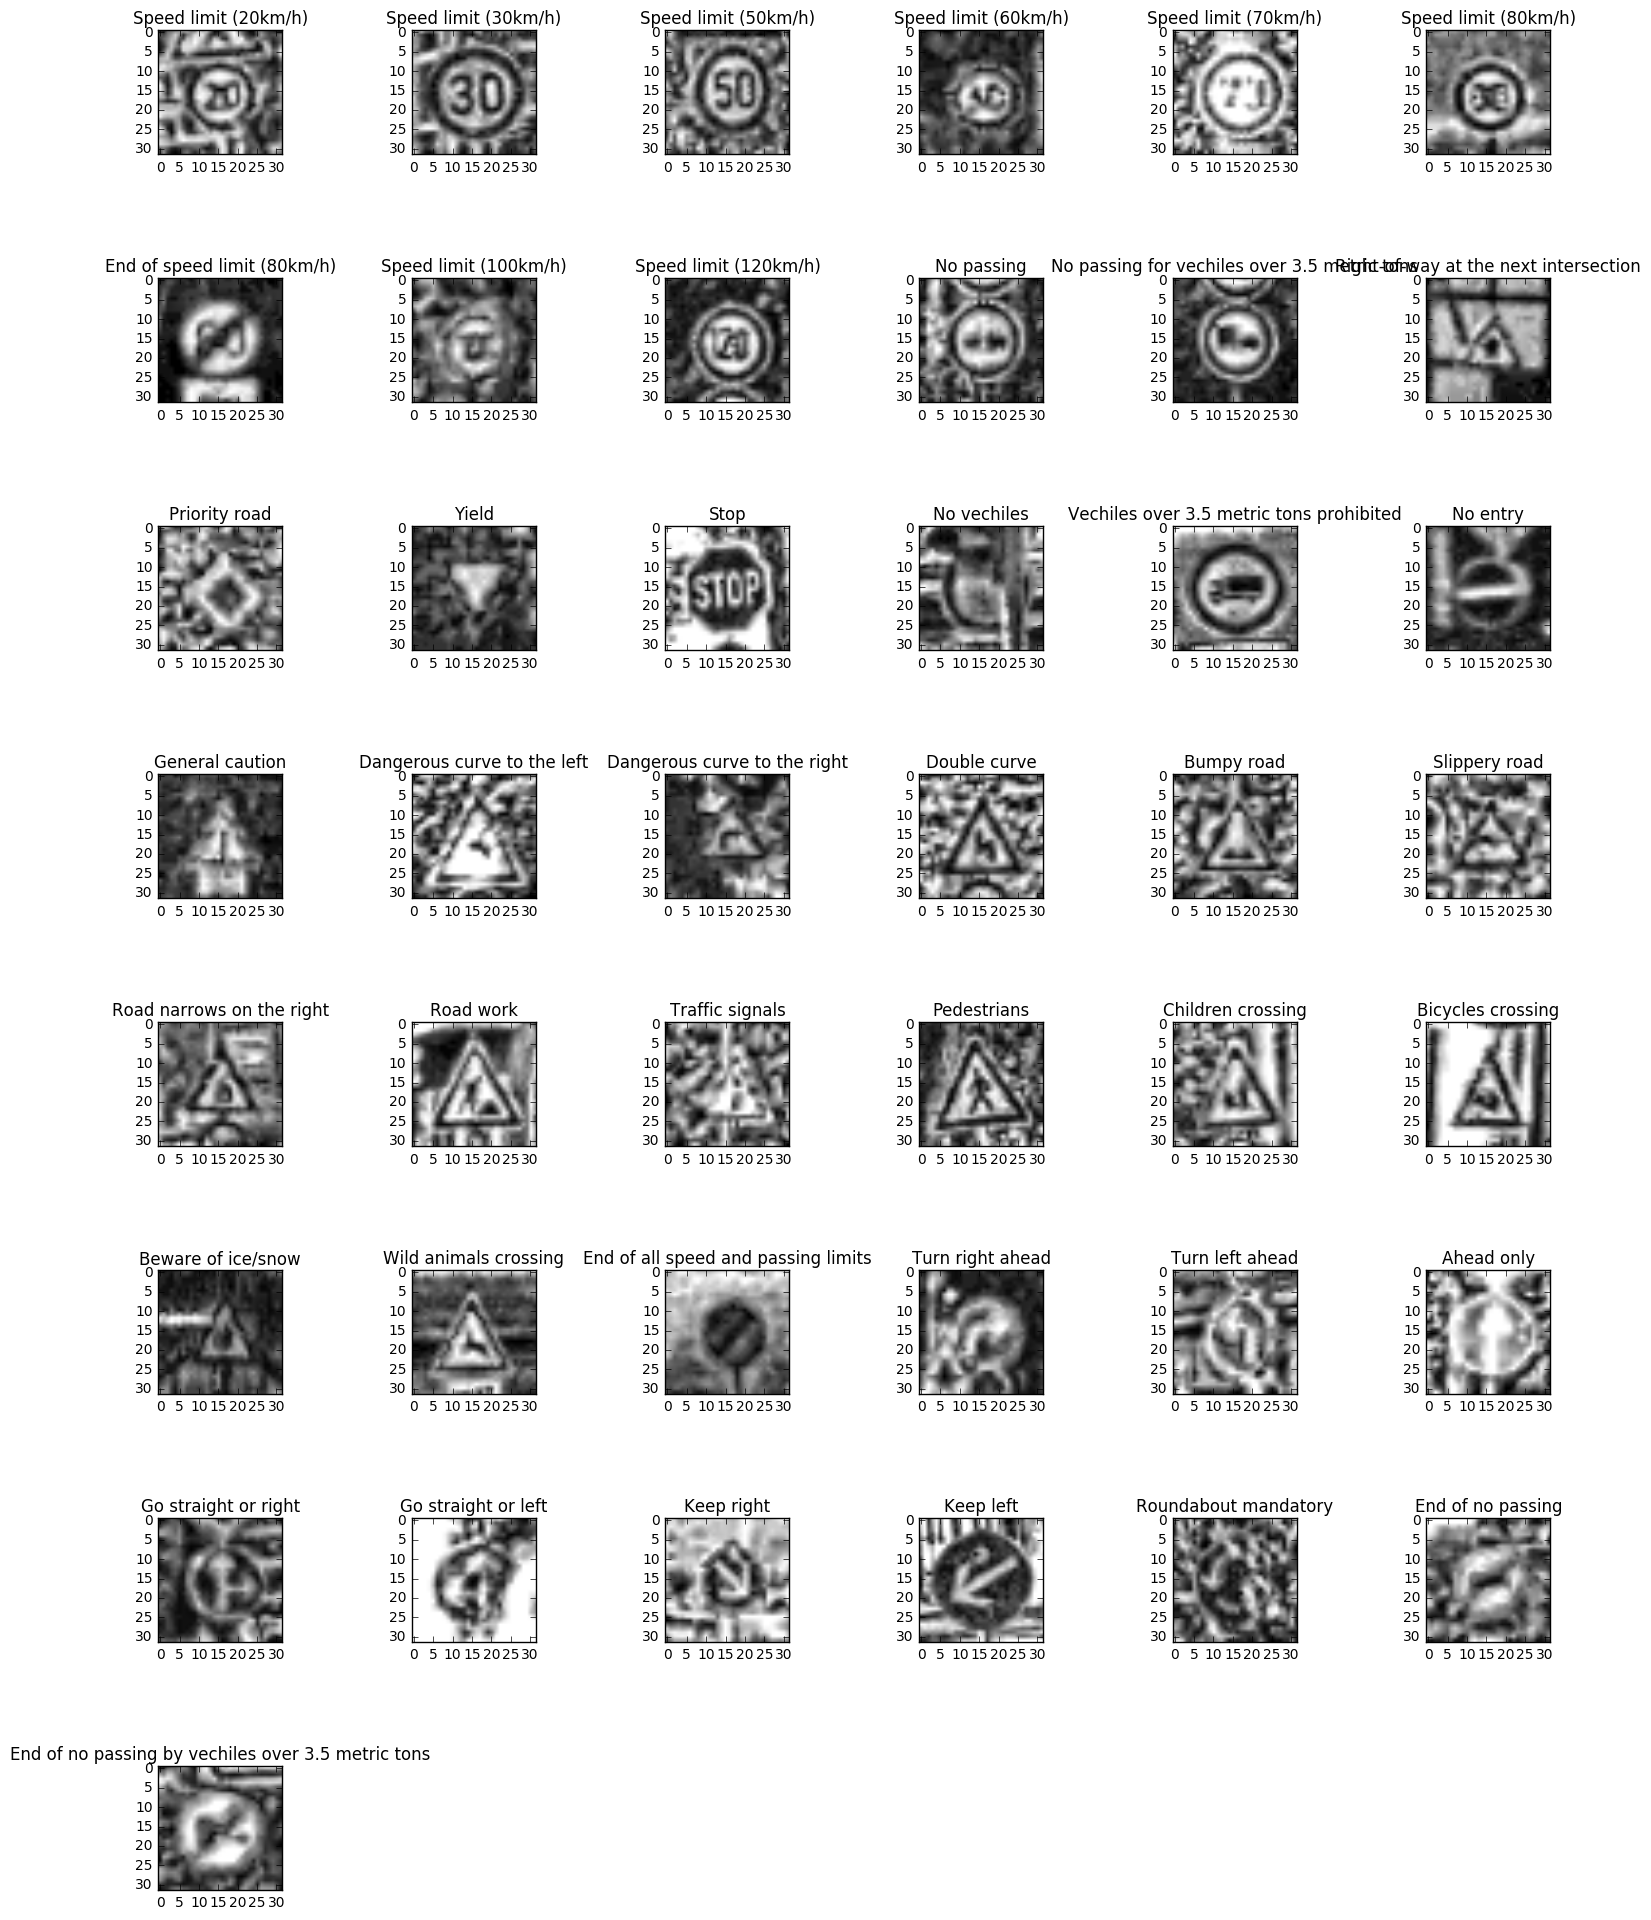

In [12]:
# Let's visualize some of our processed images
displaySomeImages(X_train_nrm, y_train)

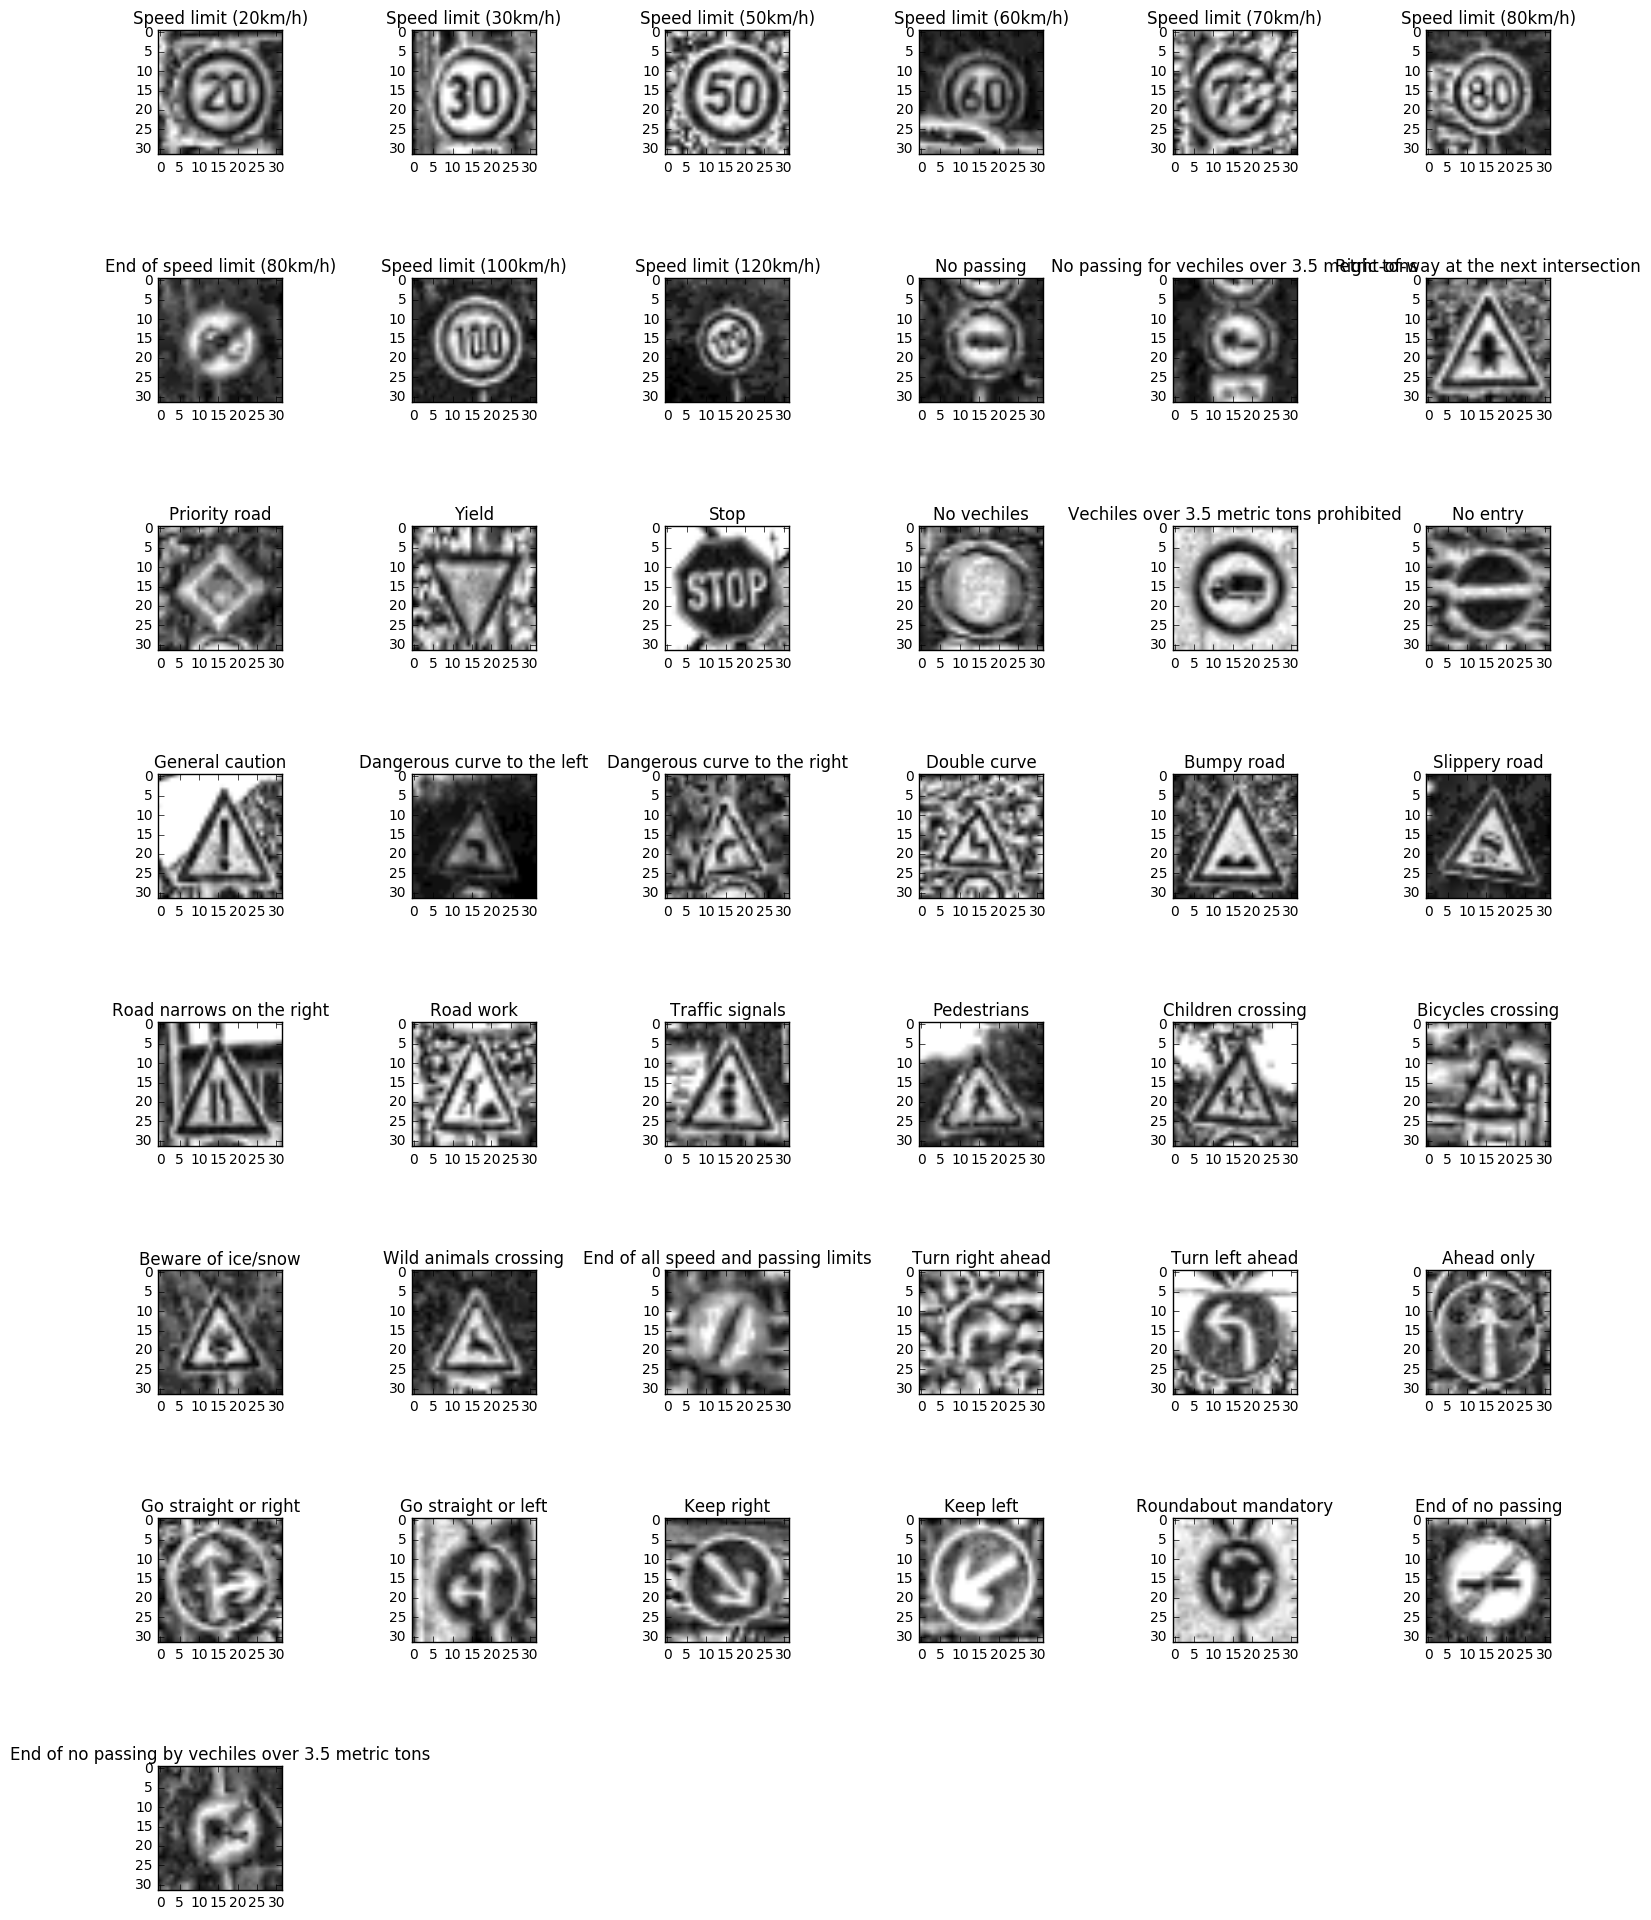

In [13]:
# Let's visualize some of our processed images
displaySomeImages(X_test_nrm, y_test)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

1. Convert to grayscale. The Seramanet paper argues the following
  * This particular networks uses grayscale only (left column) and could have clearly benefited from color information for the worst errors (top), where an arrow is hardly visible in grayscale but clearly is in color channels. We however showed that non-normalized color yielded overall worse performance.
  * We see implications of this during our final testing, where the Priority road (yellow being a color close to white when converted to grayscale) sign's performance suffers due to the lack of color information.
  * More preprocessing with normalized data could yeild better results.
  * The con to this is that it'll increase the computation time since the input will now be 3 times what we use now.
    * Could an approach of using YUV where 8 bits is given to Y, but only 4 bits each for U and V (like they do in MPEG compression) help? Need to explore this idea further.
    * This could strike a balance between computation and performance.
2. Contrast equalization using skimage exposure. I tried other equalizations / normalizations such as the following:
  * Simply normalizing by / 255.
  * Self implementing the min-max normalization
  * Using cv2.normalize on the image
  * Using cv2.equalizeHist on the image

I found the skimage exposure to give the best performance as evidenced by the images above

In [14]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [25]:
# Function to generate transformed images
# from https://nbviewer.jupyter.org/github/vxy10/SCND_notebooks/blob/master/preprocessing_stuff/img_transform_NB.ipynb

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    # Perform the transformations
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

print('Success: transform_image function loaded.')

Success: transform_image function loaded.


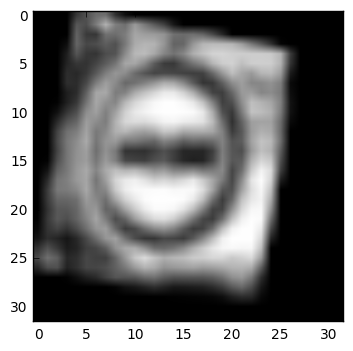

In [26]:
# Example transformation
image = random.choice(X_train_nrm)
image = transform_image(image,20,10,5)
plt.imshow(image, cmap='gray')

working on class # 0 ...
working on class # 1 ...
working on class # 2 ...
working on class # 3 ...
working on class # 4 ...
working on class # 5 ...
working on class # 6 ...
working on class # 7 ...
working on class # 8 ...
working on class # 9 ...
working on class # 10 ...
working on class # 11 ...
working on class # 12 ...
working on class # 13 ...
working on class # 14 ...
working on class # 15 ...
working on class # 16 ...
working on class # 17 ...
working on class # 18 ...
working on class # 19 ...
working on class # 20 ...
working on class # 21 ...
working on class # 22 ...
working on class # 23 ...
working on class # 24 ...
working on class # 25 ...
working on class # 26 ...
working on class # 27 ...
working on class # 28 ...
working on class # 29 ...
working on class # 30 ...
working on class # 31 ...
working on class # 32 ...
working on class # 33 ...
working on class # 34 ...
working on class # 35 ...
working on class # 36 ...
working on class # 37 ...
working on class # 38 

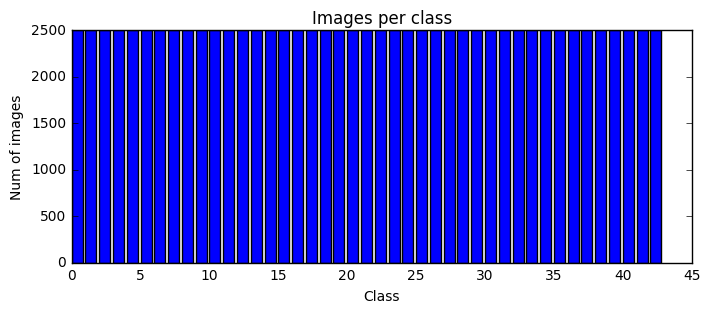

In [27]:
# figure out what's the max number of examples a class has
values, counts = np.unique(y_train, return_counts=True)
IMG_PER_CLASS = 2500 # Set this to 0 to not generate any new images

# Transform the data only if it's not yet already pickled...
pickle_file = 'transformed_data.pickle'
for class_ in values:
    print('working on class #', class_, '...')
    num_img_needed = IMG_PER_CLASS - counts[class_]

    # Create a generator to fetch the indexes corresponding to each class
    gen = (index for index, val in enumerate(y_train) if val==class_)

    # Reshape the class
    class_ = class_.reshape([1])

    # Continue as long as more images are needed
    for num in np.arange(num_img_needed):

        try:
            # Fetch an image from the class
            first_example = X_train_nrm[next(gen)]
        except:
            # Recreate the generator and try
            gen = (index for index, val in enumerate(y_train) if val==class_)
            first_example = X_train_nrm[next(gen)]

        # Transform the image
        transformed_example = transform_image(first_example,20,10,5)

        # Reshape it and add it back to the training set
        transformed_example = transformed_example.reshape([1, 32, 32])
        X_train_nrm = np.concatenate([X_train_nrm, transformed_example])
        y_train = np.concatenate([y_train, class_])

# Reform the OHE for the training labels
y_train_ohe = OneHot(y_train)
# Plot all the classes to ensure that they are equalized
plot_examples_per_class(y_train)

In [28]:
# Always save the data for easy access
print('Saving data to pickle file...')
try:
    with open('transformed_data.pickle', 'wb') as pfile:
        pickle.dump(
            {
                'X_train': X_train_nrm,
                'y_train': y_train_ohe,
                'X_test': X_test_nrm,
                'y_test': y_test_ohe
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


## Model Running
It's sufficient to execute from this point for re-running the model...

In [11]:
# Reload the data
pickle_file = 'transformed_data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train_nrm = pickle_data['X_train']
    y_train_ohe = pickle_data['y_train']
    X_test_nrm = pickle_data['X_test']
    y_test_ohe = pickle_data['y_test']
    del pickle_data  # Free up memory

print('Training and test data loaded')

Training and test data loaded


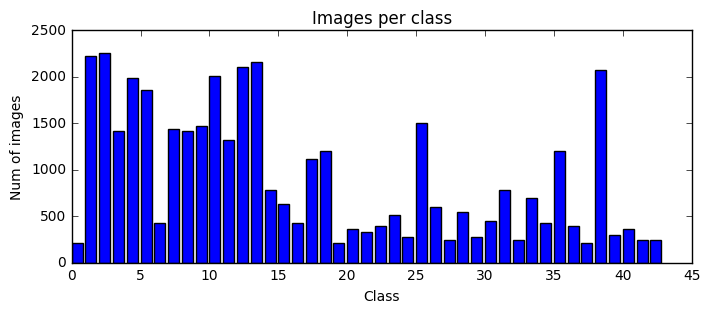

In [12]:
# Check that the labels are now evenly distributed
plot_examples_per_class(y_train)

In [13]:
def split_train_and_val(_x, _y, split=0.2):
    """
    Split the training data into training and cross-validation sets
    
    Parameters
    ----------
    _x, _y: The features and labels of the training data
    """
    (train_features, valid_features, train_labels, valid_labels) = \
        train_test_split(_x, _y, test_size = split, 
                       random_state=randint(0,np.power(2,31)), stratify = _y)
        
    return (train_features, valid_features, train_labels, valid_labels)


print('Success: Data split functions loaded.')

Success: Data split functions loaded.


In [14]:
(train_features, valid_features, train_labels, valid_labels) = \
  split_train_and_val(X_train_nrm, y_train_ohe)

test_features = X_test_nrm
test_labels = y_test_ohe

print('Success: Data sets generated.')

Success: Data sets generated.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

**Train / Validation / Test**: I split the training data into 80% - 20% for training and cross-validation, purely out of tradition.

**Additional data**: I did not generate additional data, as the time consumption was very high.

In [15]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [16]:
# Convolutional Neural Network
# Based on https://github.com/aymericdamien/TensorFlow-Examples - convolutional_network
# and "Traffice Sign Recognition with Multi-Scale Convolutional Networks" by Sermanet & LeCun

# Parameters
n_hidden_1 = 128 # Layer 1 with 100 hidden units
n_hidden_2 = 128 # Layer 2 with 100 hidden units

# Network Parameters
n_input = image_shape[0] * image_shape[1]  # img shape: 32*32
n_classes = n_classes                    # total classes
init_stdev = 0.05                        # Std. Dev of weights initialization

# Sizing parameters
pool_sizeNstride   = 2               #pooling size & stride

input_channels     = 1               #grayscale
input_size         = image_shape[0]  #size of 1 side of input square

wc1_convoSize      = 5               #size of 1 side of convo sq  
wc1_outDepth       = 12              #convo output depth
wc1_outSize        = int(input_size / pool_sizeNstride)  #size of 1 size of output sq

wc2_convoSize      = 5
wc2_outDepth       = 48
wc2_outSize        = int(wc1_outSize / pool_sizeNstride)

wc1_total          = wc1_outSize * wc1_outSize * wc1_outDepth
wc2_total          = wc2_outSize * wc2_outSize * wc2_outDepth
multiscale_len     = wc1_total + wc2_total #mutli-scale feature results

# tf Graph input
x = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1]])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)             #dropout (keep probability)

# Down-sampling
def maxpool2d(x_, k_=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x_, ksize=[1, k_, k_, 1], strides=[1, k_, k_, 1],
                          padding='SAME')

# Create some wrappers for simplicity
def conv2d(x_, W_, b_, drop_, strides_=1):
    x = tf.nn.conv2d(x_, W_, strides=[1, strides_, strides_, 1], padding='SAME')
    
    x = tf.nn.bias_add(x, b_)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, drop_)
    x = maxpool2d(x, pool_sizeNstride)    
    return x

# Create model
def model(x_, weights_, biases_, dropout_):
    # Reshape input picture
    x = tf.reshape(x_, shape=[-1, image_shape[0], image_shape[1], 1])

    # Convolution Layer 1
    conv1 = conv2d(x, weights_['wc1'], biases_['bc1'], dropout_)
    
    # Convolution Layer 2
    conv2 = conv2d(conv1, weights_['wc2'], biases_['bc2'], dropout_)
    
    # Input to classifier
    flat1 = tf.reshape(conv1, [-1, wc1_total])  #row size should be batch size
    flat2 = tf.reshape(conv2, [-1, wc2_total])  #row size should be batch size
    classifier_input = tf.concat(1, [flat1, flat2])  #should concat the rows
    
    # Hidden layer with RELU activation
    h1 = tf.add(tf.matmul(classifier_input, weights['wh1']), biases['bh1'])      #WX+b
    h1 = tf.nn.relu(h1)
    h1 = tf.nn.dropout(h1, dropout_)
    
    # Hidden layer with RELU activation
    h2 = tf.add(tf.matmul(h1, weights['wh2']), biases['bh2'])     #WX+b
    h2 = tf.nn.relu(h2)
    h2 = tf.nn.dropout(h2, dropout_)
    
    # Output, 'classifier'
    out = tf.add(tf.matmul(h2, weights_['out']), biases_['out'])
    return out

# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([wc1_convoSize, wc1_convoSize, input_channels, wc1_outDepth], stddev=init_stdev)),
    'wc2': tf.Variable(tf.random_normal([wc2_convoSize, wc2_convoSize, wc1_outDepth, wc2_outDepth], stddev=init_stdev)),
    'wh1': tf.Variable(tf.random_normal([multiscale_len, n_hidden_1], stddev=init_stdev)),
    'wh2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=init_stdev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=init_stdev))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([wc1_outDepth], stddev=init_stdev)),
    'bc2': tf.Variable(tf.random_normal([wc2_outDepth], stddev=init_stdev)),
    'bh1': tf.Variable(tf.random_normal([n_hidden_1], stddev=init_stdev)),
    'bh2': tf.Variable(tf.random_normal([n_hidden_2], stddev=init_stdev)),
    'out': tf.Variable(tf.random_normal([n_classes], stddev=init_stdev))
}

# Construct model
pred = model(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))

# L2 regularization for the fully connected parameters.
regularizers = tf.nn.l2_loss(weights['wc1']) + tf.nn.l2_loss(biases['bc1']) + \
               tf.nn.l2_loss(weights['wc2']) + tf.nn.l2_loss(biases['bc2']) + \
               tf.nn.l2_loss(weights['wh1']) + tf.nn.l2_loss(biases['bh1']) + \
               tf.nn.l2_loss(weights['wh2']) + tf.nn.l2_loss(biases['bh2']) + \
               tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out'])
                
# Add the regularization term to the loss.
beta = 1e-4
cost += beta * regularizers

print('Success: ConvNet defined.')

Success: ConvNet defined.


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

**Model Architecture: Multi-scale CNN**

Convolutional part of 2 layers:
Conv (5x5x12) -> Pool (2) -> Relu -> Conv (5x5x48) -> Pool (2) -> Relu

Fully Connected part:
Takes multi-scale (concatnates the output of both conv layers) as input, 2 layers of 128 neurons each

Most of the decisions are derived from the paper along with some changes such as the 100 to 128 neurons based on emperical results
![](ModelArch.png)

In [17]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [18]:
def evaluateModel(_x, _y, bat_sz):
    """
    Evaluates the model using either the validation or the
    test set by using batches instead of running them one
    shot. Makes it easier for bigger network architectures
    
    Parameters
    -----------
    _x, _y: The features and the labels
    bat_sz: The batch size
    return: The average (cost, accuracy) as a tuple
    """
    total_batch = int(_x.shape[0] / bat_sz)
    total_cost = 0.
    total_acc = 0.

    # Loop over all batches            
    for i in np.arange(total_batch):
        offset = i * bat_sz
        batch_x = _x[offset : offset + bat_sz]
        batch_y = _y[offset : offset + bat_sz]

        # Evaluate the cost and the accuracy
        _cost, _acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})

        # Total up the values
        total_cost += _cost
        total_acc += _acc

    # Return the average values
    return (total_cost / total_batch, total_acc * 100. / total_batch)

     Minibatch              Time                 Loss           Train accuracy    Validation accuracy 
         0           5.6395659999998315   0.0765193498135      0.071044921875       6.6845703125    
         50          197.51591499999995    1.61706832939       52.5522460938        74.35546875     
        100          196.6540819999991     0.86440611881       75.4408935547        82.67578125     
        150          195.9387770000012     0.695235005021      81.2874511719         84.8828125     
        200          195.54549899999984    0.618980062664      83.9843017578       87.0849609375    
        250          195.85944999999992    0.572851272702       85.60234375        88.4326171875    
        300          195.63477199999943    0.54128961575       86.7126464844       89.1259765625    
        350          195.27096900000106    0.519742799491      87.4344238281       89.9853515625    
        400          195.39756300000045    0.503267846435      87.9698486328         90.4

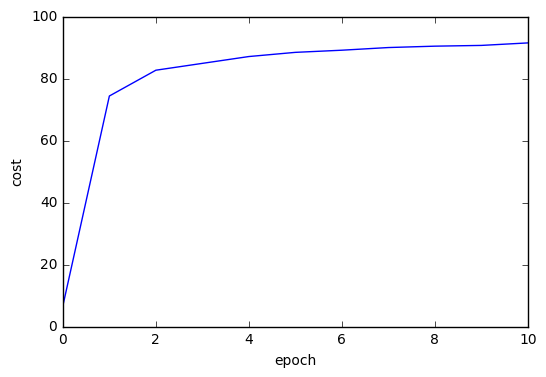

In [37]:
# Tune-ing variables
EPOCHS = 501
BAT_SZ = 4096
dropout = 0.5                            # Dropout, probability to keep units

# Display variables
display_step = int(EPOCHS / 10)
cost_batch = []     # plotting array
batch_avg_loss, batch_avg_acc = 0., 0.
prev_batch_loss = 0.

optimizer = tf.train.AdamOptimizer().minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Initializing the variables
init = tf.initialize_all_variables()

# Print the table format
print('{:^20}'.format('Minibatch'),end="")
print('{:^20}'.format('Time'),'{:^20}'.format('Loss'),end="")
print('{:^20}'.format('Train accuracy'),'{:^20}'.format('Validation accuracy'))

# Compute the number of batches required for each epoch
num_batches = int(train_features.shape[0] / BAT_SZ)
        
# Launch the graph
with tf.Session() as sess:
    # Intialize the session
    sess.run(init)
    
    # Compute the current time
    start_time = time.clock()
    
    # For each Epoch
    for epoch in np.arange(EPOCHS):
        
        # Loop over each batches            
        for i in np.arange(num_batches):
            
            offset = i * BAT_SZ
            batch_x = train_features[offset : offset + BAT_SZ]
            batch_y = train_labels[offset : offset + BAT_SZ]
            
            # Run optimization op (backprop) and cost op (to get loss value)
            _, _c, _acc = sess.run([optimizer, cost, accuracy], 
                                   feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
           
            # Compute totals so we can average later
            batch_avg_loss += _c
            batch_avg_acc += _acc
        
        # Display logs per epoch step
        if epoch % display_step == 0:
            # Calculate the averages for the training example
            batch_avg_loss /= (display_step * num_batches)
            batch_avg_acc /= (display_step * num_batches)
            
            # Evaluate the validation set
            _vc, _vacc = evaluateModel(valid_features, valid_labels, BAT_SZ)
            
            # Save the cost
            cost_batch.append(_vacc)
            
            # Print the values
            print('{:^20}'.format(str(epoch)), end = "")
            print('{:^20}'.format(str(time.clock() - start_time)), end = "")
            print('{:^20}'.format(str(batch_avg_loss)), end = "")
            print('{:^20}'.format(str(batch_avg_acc * 100)), end = "")
            print('{:^20}'.format(str(_vacc)))
            
            # Reset the values to 0
            batch_avg_loss = 0.
            batch_avg_acc = 0.
            start_time = time.clock()
          
    print("Optimization Finished!")

    
    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy - run test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Test Accuracy:", accuracy.eval({x: test_features, y: test_labels, keep_prob: 1.}) * 100.)

    # Save the variables to disk
    save_path = saver.save(sess, "model.ckpt")
    print("Model saved in file: %s" % save_path)
    
    # plot
    plt.plot(cost_batch)
    plt.ylabel('cost')
    plt.xlabel('epoch')
    plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

**Optimizer:** Adam (for the convinience of reducing hyper parameters)

**Batch Size:** The maximum that'll fit my GPU (4098)

**Epochs:** 500 (for time)

**Hyper-parameters:**
1. Dropout: 0.5 (sticking to literature here). If I try without dropouts, the model quickly overfits (achieving 100% on the training set), while the test set remains at a low 80%...
2. Beta (regularization constant): 1e-4 (just a random value...)

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

My steps
1. I tried directly doing a FC net on the original input data (with no preprocessing)
2. I tried a convNet on the original input data
  * Both the above approaches failed to yeild better than 80% accuracy
3. I tried pre-processing with just grayscale and did not get much better returns
4. I tried adding normalization (manually, min-max, cv2.normalize, etc...) and got slightly better accuracy
5. Finally tried skimage equalize and got a tremendrous boost in accuracy
6. When i tried the model without dropouts, it quickly overfit (achieving 100% on training data but only 90% on CV and even worse of 80% on test)
7. Adding dropouts of 0.5 generalized the model to achieve 90%+ on the test data

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [20]:
def img_import(file_path_):
    image = cv2.imread(file_path_)
    # make the image small in the middle
    image = cv2.resize(image, (32, 32))

    return image


print('Success: new image helper functions defined.')

Success: new image helper functions defined.


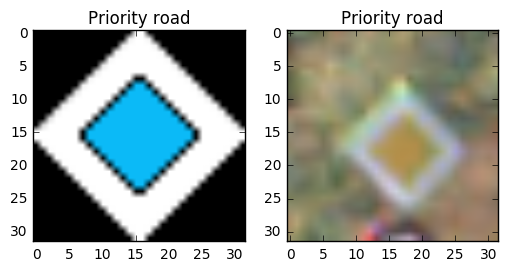

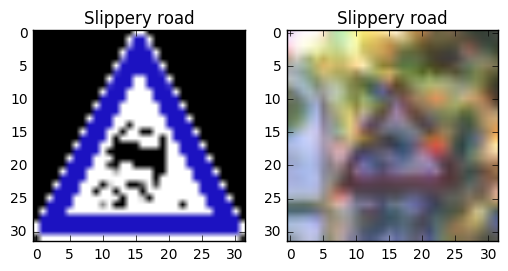

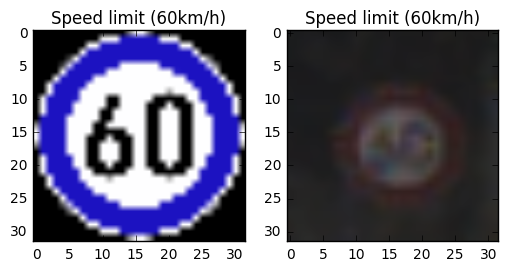

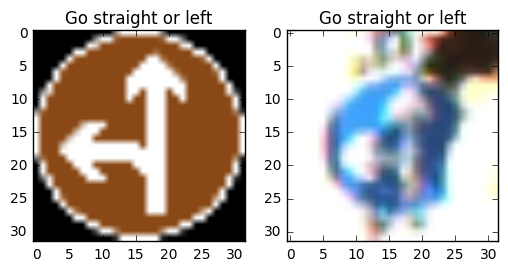

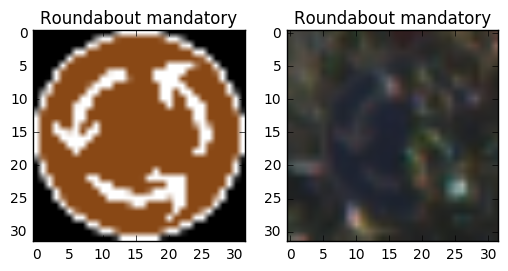

In [23]:
# Load and show images
# images from https://en.wikipedia.org/wiki/Road_signs_in_the_United_States

img_folder = 'test-data'

img_names = os.listdir(img_folder)

extra_imgs = []
extra_labels = []

for name in img_names:
    label = int(name[:name.find('.')])
    extra_imgs.append(img_import(img_folder + "/" + name))
    extra_labels.append(label)
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    a.set_title(SignNames[label])
    plt.imshow(extra_imgs[-1])
    
    # display an image from the training set that matches
    training_index = next(index for index, val in enumerate(y_train) if val == label)
    a=fig.add_subplot(1,2,2)
    a.set_title(SignNames[label])
    plt.imshow(X_train[training_index])
    
extra_imgs = np.array(extra_imgs)
extra_labels = np.array(extra_labels)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I've taken 5 images from the https://en.wikipedia.org/wiki/Road_signs_in_Germany. Given that I'm reusing the german traffic signs, it should be a pretty good match. Some difficulties might be
* The illumination is very different
* It's not a real life shot, but rather a idealized test set, so the model might find it difficult to classify some of them...
* The size of the test images are very different. It fills the entire range, while the input images are only subsets of the total image size.

Beyond this, as was pointed by my first project reviewer, some more difficulties might be
* The contrast of the images (taken with different cameras, etc...)
* Image orintation / angle. The image could have shot from any angle giving rise to any affine transform on the image. 
  * Although we've generated new images by jittering the dataset, we've to remember that we've not jittered each class equally. Our purpose in jittering the dataset was just to equalize the class distribution. To truly solve the problem, we will need to jitter all the classes and get a lot more images.
  * Then hope that udacity funds each of us to get a TitanX, so we can train on the new **HUGE** dataset ;)

So in all, this and other real world images will be a difficult set for the model to predict.

In [24]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [25]:
# Normalize the one hot the new images
extra_nrm = np.resize(equalize(grayscale(extra_imgs)),(5,32,32))
extra_ohe = np.zeros((5,43))
for i in np.arange(extra_labels.shape[0]):
    extra_ohe[i][extra_labels[i]] = 1.0

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

pred_val = tf.argmax(pred, 1)

pred_softmax = tf.nn.softmax(pred)
pred_topFive = tf.nn.top_k(pred_softmax, k = 5)

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "model.ckpt")
    print("Model restored.")
    
    # Get the predictions
    extra_soln_vals, extra_soln_topFive = sess.run([pred_val, pred_topFive], feed_dict={x: extra_nrm, keep_prob: 1.})

# Print out the results
print('Actuals: ', extra_labels)
print('Soln_vals: ', extra_soln_vals)

Model restored.
Actuals:  [12 23  3 37 40]
Soln_vals:  [12 23 34 37 40]


In [28]:
# Get 5 images of the same class from the test set and let's see how well our model precits
test_imgs = []
test_labels = []

for i in np.arange(extra_nrm.shape[0]):
    index = next(index for index, val in enumerate(y_test) if val == extra_labels[i])
    test_imgs.append(X_test_nrm[index])
    test_labels.append(y_test[index])

test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

pred_val = tf.argmax(pred, 1)

pred_softmax = tf.nn.softmax(pred)
pred_topFive = tf.nn.top_k(pred_softmax, k = 5)

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "model.ckpt")
    print("Model restored.")
    
    # Get the predictions
    test_soln_vals, test_soln_topFive = sess.run([pred_val, pred_topFive], feed_dict={x: test_imgs, keep_prob: 1.})

# Print out the results
print('Actuals: ', test_labels)
print('Soln_vals: ', test_soln_vals)

Model restored.
Actuals:  [12 23  3 37 40]
Soln_vals:  [12 23  3 37 40]


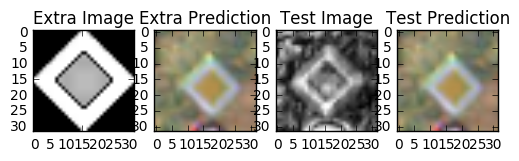

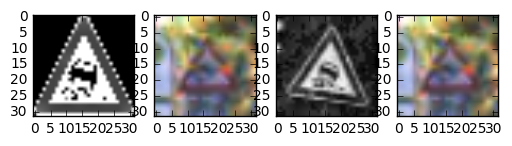

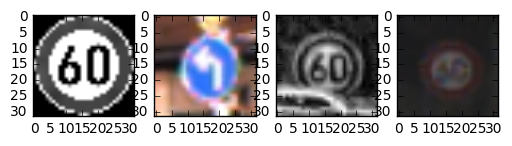

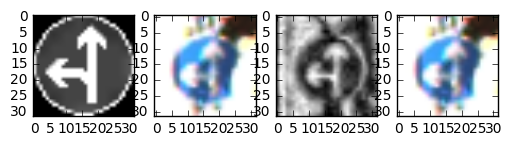

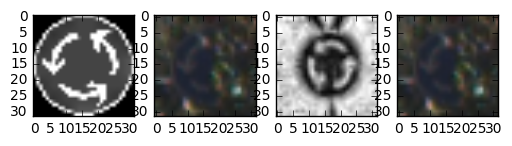

In [31]:
# Display the results
for i in np.arange(extra_nrm.shape[0]):
    fig = plt.figure()
    
    # Show the extra image
    a=fig.add_subplot(1,4,1)
    if i == 0: a.set_title("Extra Image")
    plt.imshow(extra_nrm[i], cmap='gray')
    
    # display an image from the training set that matches the extra prediction
    a=fig.add_subplot(1,4,2)
    training_index = next(index for index, val in enumerate(y_train) if val == extra_soln_vals[i])
    if i == 0: a.set_title("Extra Prediction")
    plt.imshow(X_train[training_index])
    
    # Show the test image
    a=fig.add_subplot(1,4,3)
    if i == 0: a.set_title("Test Image")
    plt.imshow(test_imgs[i], cmap='gray')
    
    # display an image from the training set that matches the test prediction
    a=fig.add_subplot(1,4,4)
    training_index = next(index for index, val in enumerate(y_train) if val == test_soln_vals[i])
    if i == 0: a.set_title("Test Prediction")
    plt.imshow(X_train[training_index])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

It does a decent job, only 1 classification missed. But for the missed case, it get's it absolutely wrong (does not even predict some other speed sign). For the corresponding image from the test set, it does really well. As was discussed before we started predicting, the scale of the images are vastly different. Considering that in the speed signs, the classifier needs to get a lot more information than primitive shapes, the scale starts to affect a lot more. I'm surprised that it gets the "priority road" sign as I expected that to be a tough test case.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

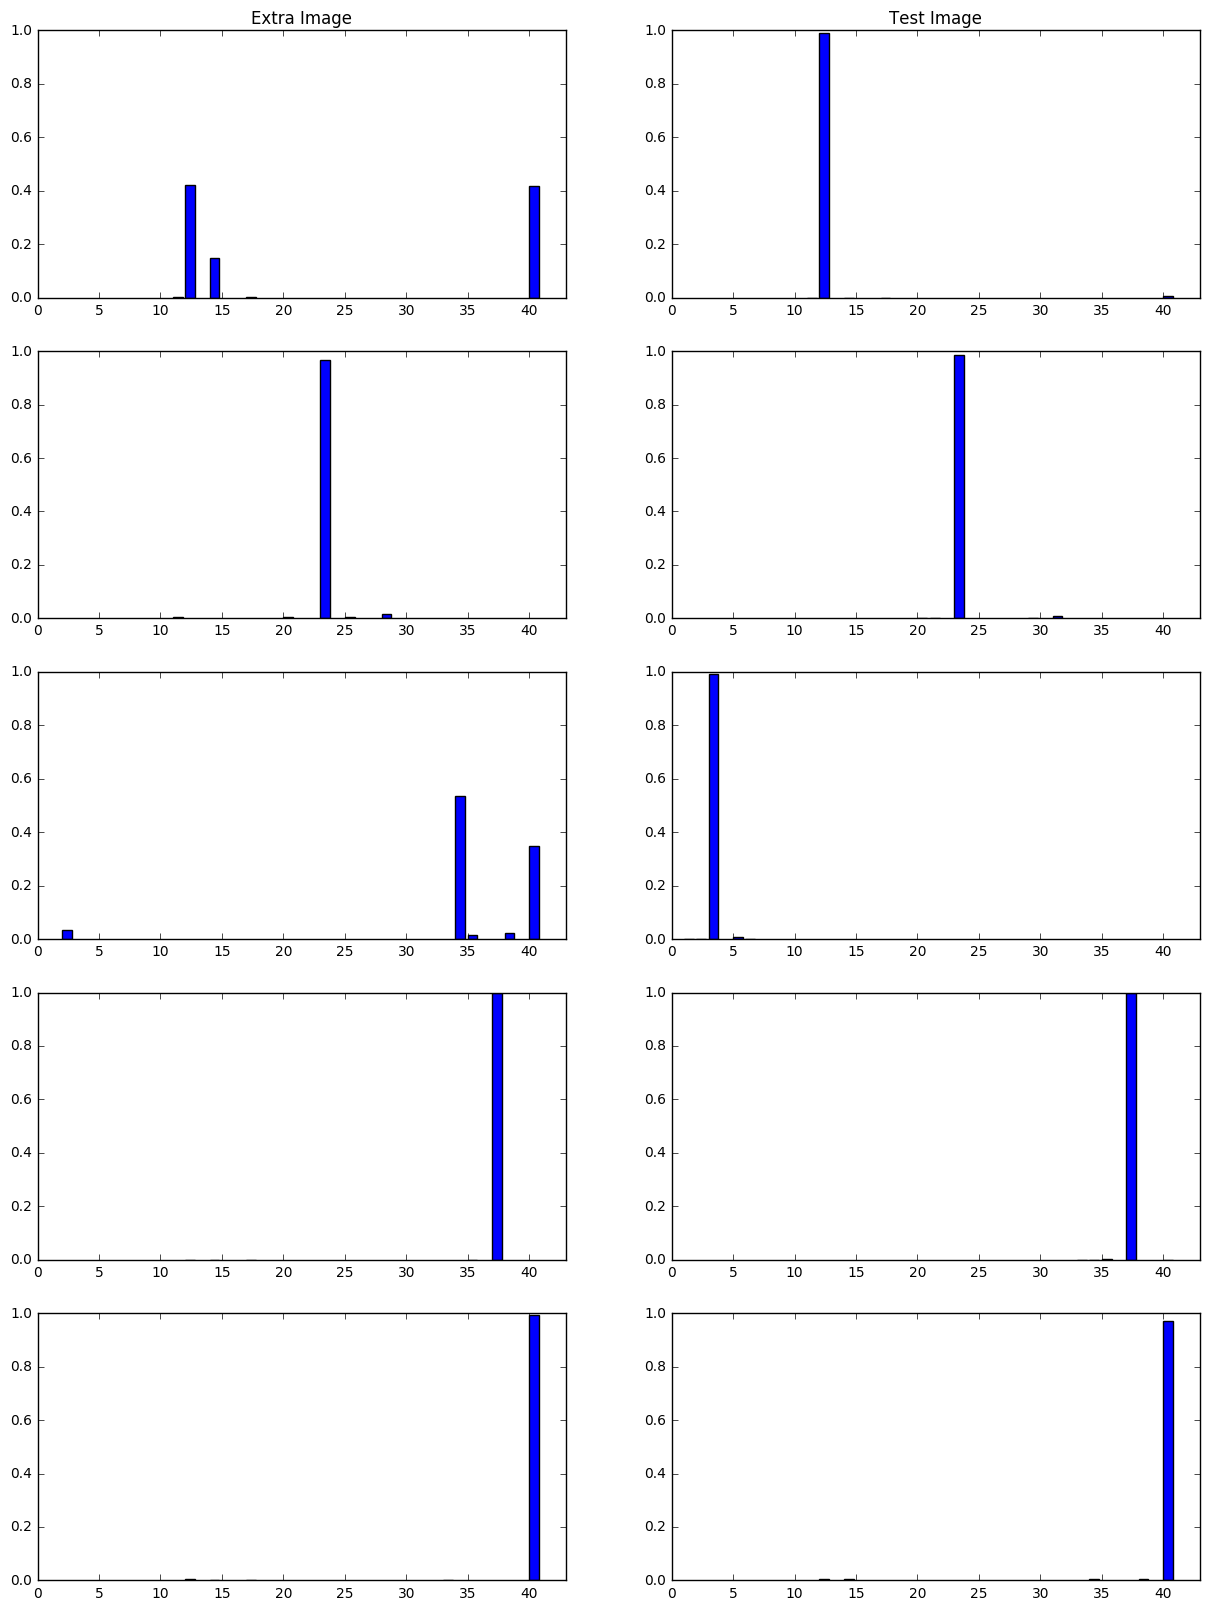

In [58]:
fig = plt.figure(figsize=(15, 20))

for i in np.arange(extra_nrm.shape[0]):
    a = fig.add_subplot(5,2,(i * 2) + 1)
    if i == 0: a.set_title("Extra Image")
    plt.bar(extra_soln_topFive.indices[i][:], extra_soln_topFive.values[i], color="blue")
    plt.axis([0, 43, 0, 1])
    
    a = fig.add_subplot(5,2,(i * 2) + 2)
    if i == 0: a.set_title("Test Image")
    plt.bar(test_soln_topFive.indices[i][:], test_soln_topFive.values[i] , color="blue")
    plt.axis([0, 43, 0, 1])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

**For 1**
Ah! the model barely manages to predict. This was a tough test case, one I expected the model to fail and it almost does. The reason here might be that it's an yellow image (the only one in the dataset). Considering that we arent using color, we could be putting the model at a disadvantage here

**For 3**
The actual correct answer does not coming in the top 5 at all. And you can see that the model is not at all confident with it's prediction and hence ends up making the mistake. My guess would be that speed indicators especially when they vary in size, is difficult for the model to predict. So it ends up matching the shape of the sign (a circle). All the top 5 models are circle signs. And it does predict 50km/h as the third highest prediction.

**Note**: In both the cases, the test set does explicitly well (no confusion at all for the model). This seems to indicate very much on the scale of the extra image that messes up the prediction

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.